In [1]:
import argparse
import logging
from collections import Counter
from pathlib import Path

import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import json

logging.basicConfig(level=logging.INFO)
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.INFO)


def is_valid_description(d):
    if type(d) != list:
        return False
    elif (type(d[0]) != str) or (pd.isna(d[0])) or (d[0] == 'No abstract available') or (d[0].strip() == ''):
        return False
    else:
        return True


def is_valid_term_set(t):
    if type(t) != list:
        return False
    elif len(t) == 0:
        return False
    else:
        return True


def clean_description(d):
    d = d[0]
    d = d.replace('\t', ' ').replace('\n', ' ').strip()
    return d


def clean_term_sets(ts):
    clean_ts = [t.strip().lower() for t in ts]
    return clean_ts


def spread_rand_select(n, l):
    interval = math.floor(len(l) / n)
    selected_terms = []
    for i in range(n):
        random_offset = np.random.randint(0, int(interval))
        index = i * interval + random_offset
        term = l[index]
        selected_terms.append(term)
    return selected_terms


def has_key_term(l, kwd0, kwd1):
    terms = [0]
    if kwd0 in l:
        terms.append(1)
    if kwd1 in l:
        terms.append(2)
    return terms


def which_terms(l, kwds):
    kwd_inds = []
    for t in l:
        try:
            i = kwds.index(t)
            kwd_inds.append(i)
        except ValueError:
            continue
    return kwd_inds


def get_repeats(record):
    repeat_records = []
    for kwd in record['label']:
        d = {'label': kwd, 'abstract': record['abstract']}
        repeat_records.append(d)
    return repeat_records

In [2]:
# def main(infile, outdir, n_terms=5, shrink_factor=0.1, balance=False):

infile = 'results_merged.json'
outdir = 'experiments/multi_test/'
shrink_factor = 0.1
min_term_threshold = 500

In [3]:
LOG.info('Reading {}'.format(infile))
df = pd.read_json(infile)

INFO:__main__:Reading results_merged.json


In [10]:
t_set = 'subject'
# t_set = 'subject.NASATerms'

In [11]:
LOG.info('Cleaning dataframe')
valid_descriptions_index = df.loc[:, 'description'].apply(is_valid_description)
valid_terms_index = df.loc[:, t_set].apply(is_valid_term_set)
valid_terms_and_descriptions = np.vectorize(lambda x, y: x and y)(valid_descriptions_index, valid_terms_index)

term_sets = df.loc[valid_terms_and_descriptions, t_set].apply(clean_term_sets).tolist()
terms = Counter([term for term_set in term_sets for term in term_set if term is not ''])
df.loc[valid_terms_and_descriptions, 'clean.NASATerms'] = term_sets

terms_over_t = [(term, count) for term, count in terms.most_common() if count >= min_term_threshold]
# selected_terms = spread_rand_select(n_terms, terms_over_t)

descriptions = df.loc[valid_terms_and_descriptions, 'description'].apply(clean_description)
valid_df = df.loc[valid_terms_and_descriptions, :]

INFO:__main__:Cleaning dataframe


91
1.0115592350718248


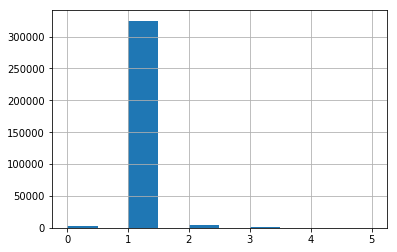

In [91]:
id_to_label = {i: l[0] for i, l in enumerate(terms_over_t)}
label_to_id = {l[0]: i for i, l in enumerate(terms_over_t)}
print(len(id_to_label))

term_ids = np.vectorize(lambda ts: tuple(label_to_id[t] for t in ts if t in label_to_id), otypes=[list])(valid_df['clean.NASATerms'])

full_ml_set = pd.DataFrame()
full_ml_set['label'] = term_ids
full_ml_set['abstract'] = valid_df.loc[:, 'description'].apply(lambda x: x[0])
full_ml_set = full_ml_set[~full_ml_set.abstract.isna()]
full_ml_set = full_ml_set[~full_ml_set.label.isna()]

nu_kwds = full_ml_set['label'].apply(lambda x: len(x))
nu_kwds.hist()
print(nu_kwds.mean())
plt.show()

shrink_factor = 0.0001
shrink_nu = math.ceil(len(full_ml_set) * shrink_factor)
shuffled_df = full_ml_set.sample(shrink_nu)

s = 0.333333333
train_test_delim = math.ceil(len(shuffled_df) * s)

ml_sets = {}
ml_sets['train'] = shuffled_df.iloc[0:train_test_delim]
ml_sets['test'] = shuffled_df.iloc[train_test_delim: 2 * train_test_delim]
ml_sets['dev'] = shuffled_df.iloc[2 * train_test_delim:]

all_kwds = pd.Series()
expanded_sets = {}
col_order = ['label', 'abstract']
for set_type, ml_set in ml_sets.items():
    repeats = ml_set.apply(get_repeats, axis=1)
    all_records = [repeat for repeat_set in repeats for repeat in repeat_set]
    repeated_df = pd.DataFrame(all_records)
    all_kwds = all_kwds.append(repeated_df.label)
    expanded_sets[set_type] = repeated_df.sample(len(repeated_df))[col_order]

In [92]:
gb = full_ml_set.groupby('label')

In [93]:
label_counts = gb.count()
label_counts = label_counts.reset_index()

In [99]:
i = 21
print(id_to_label[i])
label_counts[label_counts.index == (i, )]
label_counts[label_counts.label.apply(lambda x: i in x)].sort_values('abstract', ascending=False)

aircraft design, testing and performance


,label,abstract
904,"(21,)",5209
906,"(21, 5)",22
1026,"(24, 21)",20
177,"(5, 21)",15
932,"(21, 36)",15
1336,"(36, 21)",13
1313,"(35, 21)",13
921,"(21, 24)",12
1115,"(27, 21)",12
925,"(21, 27)",11


In [263]:
for set_type, ml_set in expanded_sets.items():
    outfile = outdir / Path('{}.tsv'.format(set_type))
    ml_set[ml_set.label.notna()].to_csv(outfile, sep='\t', index=False)

out_id_to_label = str(outdir / Path('id_to_label.json'))
out_label_to_id = str(outdir / Path('label_to_id.json'))

with open(out_id_to_label, 'w') as f0:
    json.dump(id_to_label, f0)
    
with open(out_label_to_id, 'w') as f0:
    json.dump(label_to_id, f0)

In [274]:
ml_sets['train']['abstract'].iloc[0]

'This paper presents the results of a field program using a ground-based Raman lidar system to observe changes in moisture profiles as a cold and a warm front passed over the NASA/Goddard Space Flight Center in Greenbelt, Maryland. The lidar operating only during darkness is capable of providing continuous high vertical resolution profiles of water vapor mixing ratio and aerosol scattering ratio from near the surface to about 7 km altitude. The lidar data acquired on three consecutive nights from shortly after sunset to shortly before sunrise, along with upper air data from specially launched rawinsondes, have provided a unique visualization of the detailed structure of the two fronts.'